<a href="https://colab.research.google.com/github/gwenmlondy/A-B-test/blob/main/etf_empirical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 4: Empirical Analysis of ETFs**

---

## **Introduction**

This is an Empirical Analysis of the SPDR® S&P Health Care Equipment ETF (XHE)

---

## **About the ETF:**

The SPDR® S&P Health Care Equipment ETF (XHE) is a US EFT in the  health care equipment and supplies industry.

---

## **Content**
Sector ETF - SPDR® S&P Health Care Equipment ETF (XHE)

*   a. The 30 largest holdings.
*   b. 12 months of data
*   c. Daily returns
*   d. The covariance matrix
*   e. The PCA  (Principal Component Analysis)
*   f. The SVD (Singular Value Decomposition)*italicized text*

In [1]:
#Import Libraries and Setup
!pip install openpyxl --quiet

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, Markdown
from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd

#**a. A list of the The 30 largest holdings in the SPDR® S&P Health Care Equipment ETF**

The below listings is on the top 30 holdings in the SPDR® S&P Health Care Equipment ETF (XHE). This ETF specilizes on Health Care Equipment and is based in the U.S. Its base currency is therfore USD.

It is noteworthy that the top 30 holdings carry 55.54% of the total ETF with the higest weight held be the BOSTON SCIENTIFIC CORP (BSX) with a total weight of 1.93 %

The ETFs Weighted Average Market Cap is $25,214.05 M (as of Jul 01 2025)

Data retrived from the site: State Street Corporation on 28 june 2025
https://www.ssga.com/us/en/intermediary/etfs/spdr-sp-health-care-equipment-etf-xhe

In [2]:
# Read the spreadsheet starting from row 6 (skip first 5 rows)
df = pd.read_excel('/content/holdings-daily-us-en-xhe.xlsx', skiprows=5)

# Rename columns if needed
df.columns = ["Name", "Ticker", "Identifier", "SEDOL", "Weight", "Sector", "Shares Held", "Local Currency"]

# Convert Weight to numeric
df["Weight"] = pd.to_numeric(df["Weight"], errors='coerce')

# Drop rows with missing tickers or weights
df = df.dropna(subset=["Ticker", "Weight"])

In [3]:
top_30 = df.sort_values("Weight", ascending=False).head(30)
top_30_tickers = top_30["Ticker"].tolist()

print("Top 30 tickers:")
print(top_30_tickers)

Top 30 tickers:
['BSX', 'HAE', 'IRTC', 'PODD', 'DXCM', 'SYK', 'ISRG', 'EW', 'NVST', 'GEHC', 'GKOS', 'RMD', 'ITGR', 'ALGN', 'HOLX', 'IDXX', 'SOLV', 'PEN', 'LNTH', 'MASI', 'ATRC', 'LMAT', 'STE', 'ABT', 'NVCR', 'BDX', 'XRAY', 'MMSI', 'LIVN', 'INSP']


In [4]:
# Filter original dataframe to keep only top 30 tickers
top_30_table = df[df["Ticker"].isin(top_30_tickers)][["Ticker", "Name", "Weight"]]

# Sort to match order of top_30_tickers list
top_30_table = top_30_table.set_index("Ticker").loc[top_30_tickers].reset_index()
top_30_table["Cumulative Weight"] = top_30_table["Weight"].cumsum()

# Display the heading
display(Markdown("### 30 Largest Holdings in the SPDR® S&P Health Care Equipment ETF as of 28 June 2025"))

# Display the DataFrame
display(top_30_table)

### 30 Largest Holdings in the SPDR® S&P Health Care Equipment ETF as of 28 June 2025

,Ticker,Name,Weight,Cumulative Weight
0,BSX,BOSTON SCIENTIFIC CORP,1.932335,1.932335
1,HAE,HAEMONETICS CORP/MASS,1.920556,3.852891
2,IRTC,IRHYTHM TECHNOLOGIES INC,1.902881,5.755772
3,PODD,INSULET CORP,1.882810,7.638582
4,DXCM,DEXCOM INC,1.882265,9.520847
5,SYK,STRYKER CORP,1.882100,11.402947
6,ISRG,INTUITIVE SURGICAL INC,1.878257,13.281204
7,EW,EDWARDS LIFESCIENCES CORP,1.877665,15.158869
8,NVST,ENVISTA HOLDINGS CORP,1.876872,17.035741
9,GEHC,GE HEALTHCARE TECHNOLOGY,1.873281,18.909022


# **b. Daily adjusted close prices for the SPDR® S&P Health Care Equipment ETF**

The for this Daily adjusted close prices run for 12 Months (1 June 2024 to 1 June 2025)


*  250 rows: ~250 trading days
*  30 columns: listing the 30 tickers


In [5]:
# Use previously extracted list of top 30 tickers
tickers = [
    'BSX', 'HAE', 'IRTC', 'PODD', 'DXCM', 'SYK', 'ISRG', 'EW', 'NVST', 'GEHC',
    'GKOS', 'RMD', 'ITGR', 'ALGN', 'HOLX', 'IDXX', 'SOLV', 'PEN', 'LNTH', 'MASI',
    'ATRC', 'LMAT', 'STE', 'ABT', 'NVCR', 'BDX', 'XRAY', 'MMSI', 'LIVN', 'INSP'
]

# Define fixed start and end dates
start = pd.Timestamp("2024-06-01")
end = pd.Timestamp("2025-06-01")

# Download daily adjusted close prices within the date range
prices = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"]

# Drop any rows with missing data
prices = prices.dropna(how='any')

# Display first 20 rows
prices.head(20)

[*********************100%***********************]  30 of 30 completed


Ticker,ABT,ALGN,ATRC,BDX,BSX,DXCM,EW,GEHC,GKOS,HAE,...,MMSI,NVCR,NVST,PEN,PODD,RMD,SOLV,STE,SYK,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-03,100.848312,254.529999,22.420000,233.329956,75.500000,115.230003,87.860001,77.024132,114.339996,85.000000,...,82.180000,23.889999,18.799999,188.039993,181.419998,205.540329,57.049999,226.122513,335.562927,26.910395
2024-06-04,101.397301,248.910004,22.510000,232.997803,75.919998,116.709999,87.410004,77.393517,111.629997,87.930000,...,82.790001,22.820000,18.580000,190.860001,181.809998,209.296524,55.610001,226.251251,338.143494,26.603285
2024-06-05,101.201233,256.010010,22.200001,230.848541,75.889999,118.080002,87.070000,76.834435,114.709999,88.849998,...,83.330002,23.129999,18.540001,193.289993,187.679993,211.338165,55.730000,227.647385,342.088501,26.526508
2024-06-06,102.220787,257.459991,22.580000,234.629272,76.120003,115.300003,87.680000,76.874374,113.959999,87.379997,...,83.559998,22.150000,18.440001,196.410004,192.419998,209.673126,55.049999,228.211761,345.687469,26.660870
2024-06-07,105.465736,255.539993,22.420000,235.078659,77.110001,115.790001,88.139999,76.215439,113.910004,85.610001,...,82.379997,21.500000,18.250000,188.949997,191.419998,209.028931,56.410000,224.617508,345.390808,26.574495
2024-06-10,105.377510,255.699997,21.850000,234.911911,77.419998,116.570000,86.099998,75.656357,113.000000,85.849998,...,82.220001,21.459999,18.170000,188.059998,192.039993,209.772263,56.709999,222.577744,344.243927,25.960278
2024-06-11,103.730522,253.279999,21.920000,230.429657,77.150002,116.900002,87.000000,74.618057,113.169998,83.410004,...,82.410004,21.410000,18.129999,189.940002,192.160004,208.305420,56.540001,223.221375,342.493866,25.873901
2024-06-12,102.328629,266.130005,22.059999,229.497894,77.410004,117.199997,87.769997,75.846046,113.480003,85.930000,...,83.250000,21.250000,18.170000,191.770004,200.669998,209.009109,56.160000,224.134415,342.503723,25.960278
2024-06-13,101.416901,271.279999,20.969999,227.516678,76.959999,113.809998,87.669998,76.864372,113.629997,86.050003,...,82.730003,21.520000,17.830000,188.000000,201.839996,210.485825,54.130001,219.380600,339.151978,25.624378


In [6]:
print("Tickers retained:", prices.columns.tolist())
print("Date range:", prices.index.min(), "to", prices.index.max())
print("Data shape:", prices.shape)

Tickers retained: ['ABT', 'ALGN', 'ATRC', 'BDX', 'BSX', 'DXCM', 'EW', 'GEHC', 'GKOS', 'HAE', 'HOLX', 'IDXX', 'INSP', 'IRTC', 'ISRG', 'ITGR', 'LIVN', 'LMAT', 'LNTH', 'MASI', 'MMSI', 'NVCR', 'NVST', 'PEN', 'PODD', 'RMD', 'SOLV', 'STE', 'SYK', 'XRAY']
Date range: 2024-06-03 00:00:00 to 2025-05-30 00:00:00
Data shape: (249, 30)


#c. Daily returns for the top 30 Tickers


*   Graph 1: Cumulative Log Returns: SPDR® S&P Health Care Equipment ETFs (A Graph of the cumulative log returns of each individual ticker)

*   Graph 2: Estimated Cumulative Return: SPDR® S&P Health Care Equipment ETF graph (A Graph of the equal-weghted average of the cummulative log retuns accross the 30 tickers)



### Graph 2: Cumulative Log Returns: SPDR® S&P Health Care Equipment ETFs

This graph highlighes the equal-weighted average of the cumulative log returns of its top 30 holdings. Graph allows the EFTs to be view as a whole removing market capitalization bias and dampens the influence of outliers. This provides a more balanced view of sector performance and allows for the comparison of the Individual holdings that may have extreme outliers.

In [7]:
# Calculate daily percentage returns
returns = prices.pct_change().dropna()

# Display the first few rows
returns.head()

Ticker,ABT,ALGN,ATRC,BDX,BSX,DXCM,EW,GEHC,GKOS,HAE,...,MMSI,NVCR,NVST,PEN,PODD,RMD,SOLV,STE,SYK,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-04,0.005444,-0.022080,0.004014,-0.001424,0.005563,0.012844,-0.005122,0.004796,-0.023701,0.034471,...,0.007423,-0.044789,-0.011702,0.014997,0.002150,0.018275,-0.025241,0.000569,0.007690,-0.011412
2024-06-05,-0.001934,0.028524,-0.013772,-0.009224,-0.000395,0.011739,-0.003890,-0.007224,0.027591,0.010463,...,0.006523,0.013585,-0.002153,0.012732,0.032286,0.009755,0.002158,0.006171,0.011667,-0.002886
2024-06-06,0.010075,0.005664,0.017117,0.016378,0.003031,-0.023543,0.007006,0.000520,-0.006538,-0.016545,...,0.002760,-0.042369,-0.005394,0.016142,0.025256,-0.007879,-0.012202,0.002479,0.010521,0.005065
2024-06-07,0.031745,-0.007457,-0.007086,0.001915,0.013006,0.004250,0.005246,-0.008572,-0.000439,-0.020256,...,-0.014122,-0.029345,-0.010304,-0.037982,-0.005197,-0.003072,0.024705,-0.015750,-0.000858,-0.003240
2024-06-10,-0.000837,0.000626,-0.025424,-0.000709,0.004020,0.006736,-0.023145,-0.007336,-0.007989,0.002803,...,-0.001942,-0.001861,-0.004384,-0.004710,0.003239,0.003556,0.005318,-0.009081,-0.003321,-0.023113


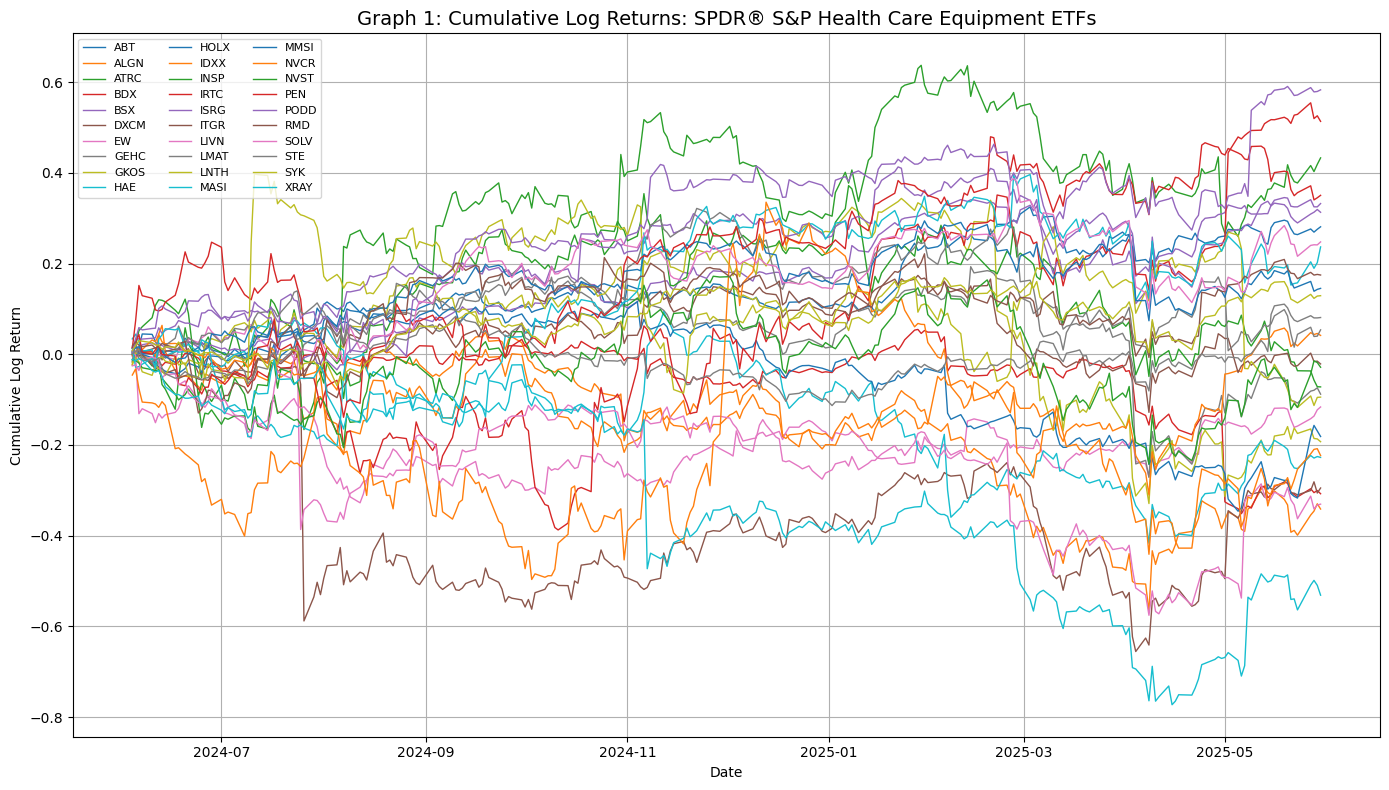

In [8]:
# Compute log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Calculate cumulative log returns
cumulative_returns = returns.cumsum()

# Plot
plt.figure(figsize=(14, 8))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker, linewidth=1)

plt.title("Graph 1: Cumulative Log Returns: SPDR® S&P Health Care Equipment ETFs", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend(ncol=3, fontsize=8, loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Compute daily log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Estimate ETF return as the average of the 30 top listings
etf_proxy_returns = returns.mean(axis=1)

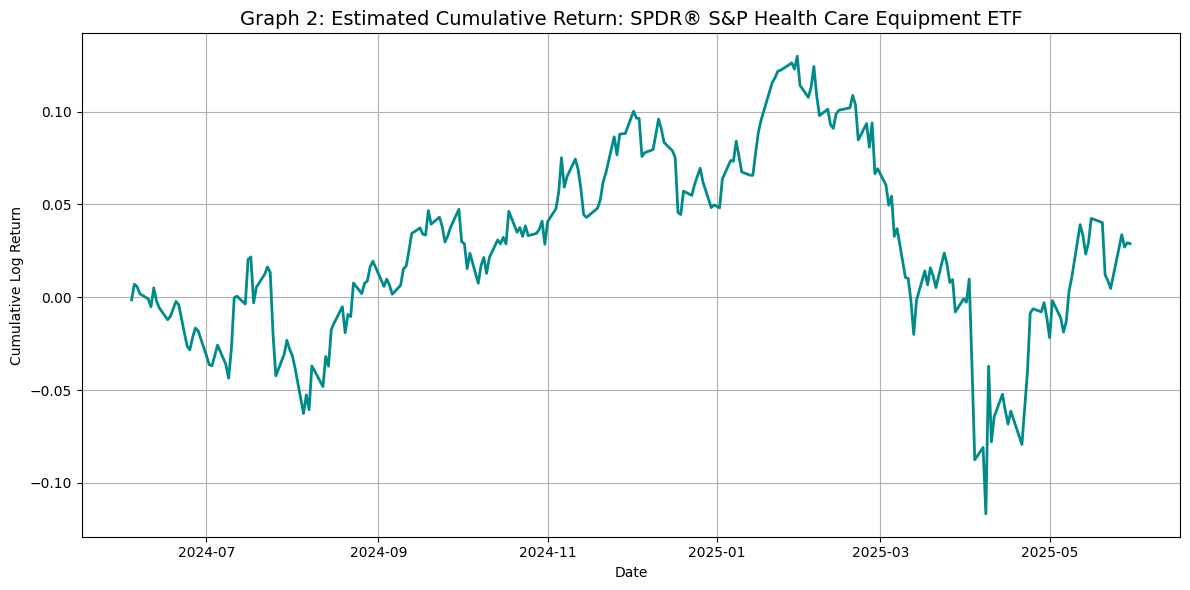

In [10]:
# Compute daily log returns for tickers
returns = np.log(prices / prices.shift(1)).dropna()

# Estimate equal-weighted ETF returns
etf_proxy_returns = returns.mean(axis=1)

# Cumulative return over time
cumulative_etf_returns = etf_proxy_returns.cumsum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_etf_returns.index, cumulative_etf_returns, color='darkcyan', linewidth=2)

plt.title("Graph 2: Estimated Cumulative Return: SPDR® S&P Health Care Equipment ETF", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# **d. The Covariance Matrix**

The covariance matrix is a 30 rows × 30 columns that reflect the variance of the 30 tickers this highlights the volatility of the top 30 holdings


In [11]:
# Log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Covariance matrix
cov_matrix = returns.cov()

# Display the matrix
cov_matrix.round(6)

Ticker,ABT,ALGN,ATRC,BDX,BSX,DXCM,EW,GEHC,GKOS,HAE,...,MMSI,NVCR,NVST,PEN,PODD,RMD,SOLV,STE,SYK,XRAY
Ticker,,,,,,,,,,,,,,,,,,,,,
ABT,0.000175,0.000033,0.000099,0.000079,0.000076,0.000095,0.000061,0.000083,0.000032,0.000074,...,0.000062,0.000020,0.000077,0.000052,0.000046,0.000093,0.000076,0.000081,0.000094,0.000087
ALGN,0.000033,0.000669,0.000291,0.000072,0.000130,0.000327,0.000237,0.000217,0.000378,0.000201,...,0.000164,0.000460,0.000443,0.000203,0.000217,0.000188,0.000230,0.000125,0.000138,0.000394
ATRC,0.000099,0.000291,0.001052,0.000138,0.000145,0.000410,0.000132,0.000190,0.000308,0.000115,...,0.000180,0.000425,0.000352,0.000223,0.000186,0.000196,0.000213,0.000128,0.000146,0.000281
BDX,0.000079,0.000072,0.000138,0.000348,0.000078,0.000047,0.000087,0.000167,0.000212,0.000100,...,0.000120,0.000154,0.000112,0.000088,0.000079,0.000090,0.000135,0.000119,0.000096,0.000193
BSX,0.000076,0.000130,0.000145,0.000078,0.000203,0.000138,0.000181,0.000166,0.000186,0.000068,...,0.000152,0.000072,0.000134,0.000135,0.000151,0.000088,0.000082,0.000077,0.000139,0.000069
DXCM,0.000095,0.000327,0.000410,0.000047,0.000138,0.001774,0.000073,0.000207,0.000330,0.000108,...,0.000147,0.000169,0.000272,0.000346,0.000232,0.000317,0.000153,0.000072,0.000128,0.000216
EW,0.000061,0.000237,0.000132,0.000087,0.000181,0.000073,0.000845,0.000108,0.000212,0.000056,...,0.000145,0.000071,0.000105,0.000136,0.000129,0.000061,0.000081,0.000076,0.000157,0.000075
GEHC,0.000083,0.000217,0.000190,0.000167,0.000166,0.000207,0.000108,0.000471,0.000283,0.000143,...,0.000213,0.000271,0.000294,0.000166,0.000181,0.000189,0.000248,0.000135,0.000161,0.000225
GKOS,0.000032,0.000378,0.000308,0.000212,0.000186,0.000330,0.000212,0.000283,0.000996,0.000132,...,0.000232,0.000310,0.000354,0.000262,0.000265,0.000161,0.000218,0.000125,0.000180,0.000293


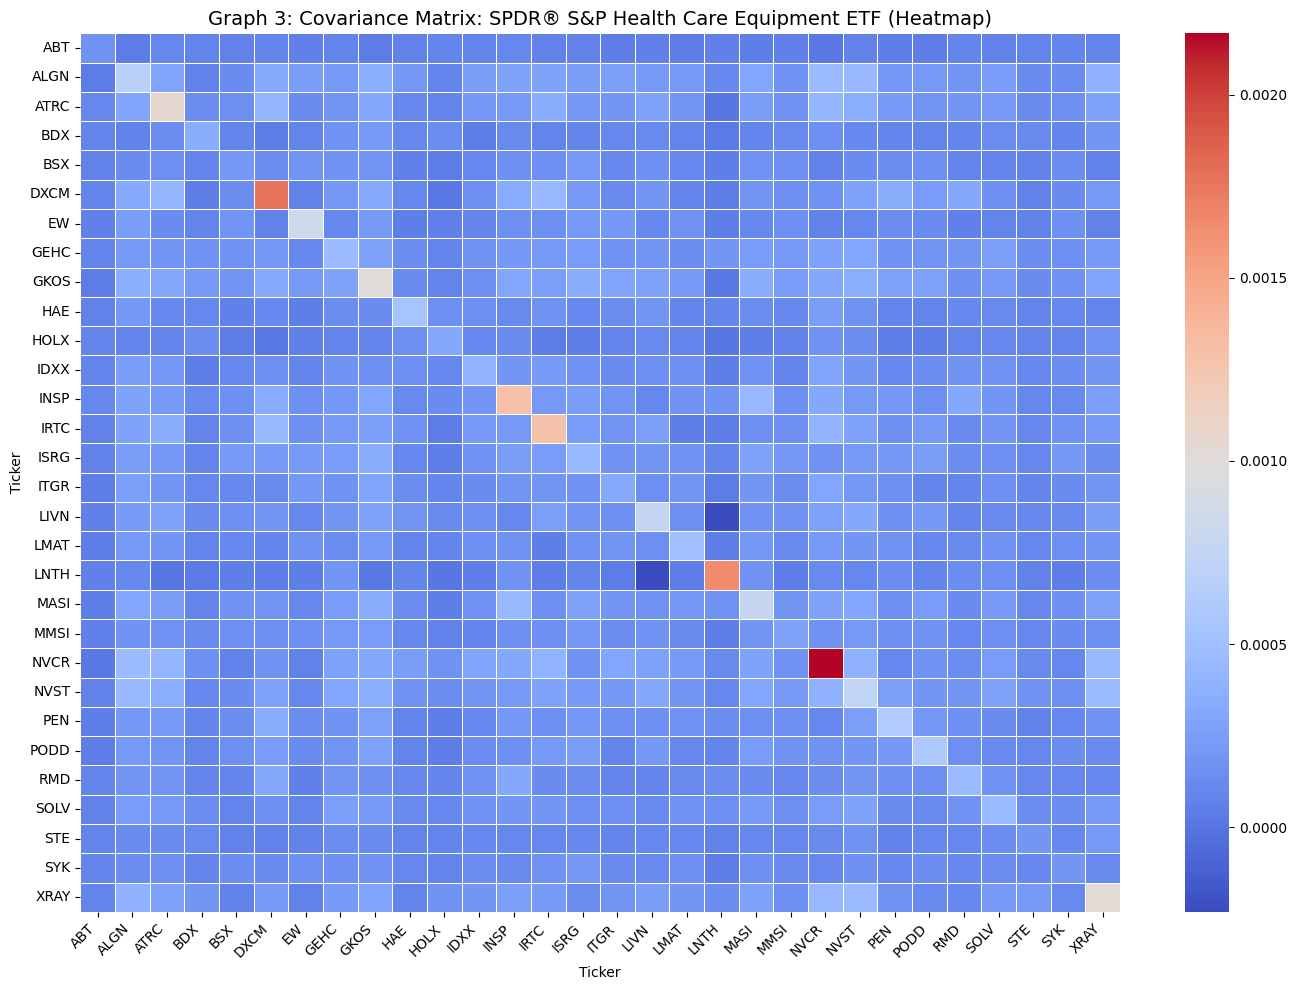

In [12]:
# Compute log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Covariance matrix
cov_matrix = returns.cov()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cov_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Graph 3: Covariance Matrix: SPDR® S&P Health Care Equipment ETF (Heatmap)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# e. The PCA  (Principal Component Analysis)

Flattens the data fromthe 2 dimenisnal graph in the Covariance matrix to anaylise a new set of uncorrelated variables refered to as the principal components.

The Principal components:

*   PC1 (Principal Component 1) this captures the largest common movement variance across the ETF (to 30 holdings)
*   PC2 (Principal Component 2) captures the second largest common movement variance with an  orthogonal direction (no information overlap)

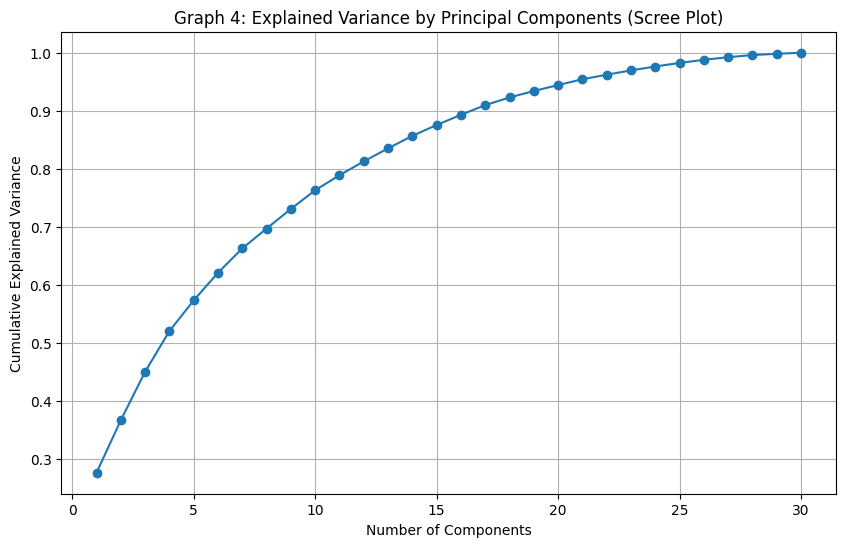

In [13]:
# Apply PCA
pca = PCA()
pca.fit(returns)

# Eigenvalues
eigenvalues = pca.explained_variance_

# Normalized
explained_variance_ratio = pca.explained_variance_ratio_

# Eigenvectors
principal_components = pca.components_

# Scree Plot: visualize how many PCs explain most of the variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Graph 4: Explained Variance by Principal Components (Scree Plot)')
plt.grid(True)
plt.show()


# f. The SVD (Singular Value Decomposition)

The Singular Value Decomposition builds on the PCA (Principal Component Analysis) it take the data that is central to the covariance matrix and computes the variance from that point.

In [14]:
# Standardize
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

# Apply SVD
U, S, VT = svd(scaled_returns, full_matrices=False)

# Display singular values
print("Singular Values:")
print(np.round(S, 4))

Singular Values:
[48.5135 21.1523 20.1987 18.9815 17.9764 16.914  16.1352 15.6031 15.1906
 14.9533 14.2793 13.6355 13.5718 12.6606 12.4117 12.231  11.7395 11.4479
 11.2694 10.6857 10.579   9.9413  9.5981  9.1273  8.979   8.6135  8.4362
  7.4179  6.8078  6.4655]


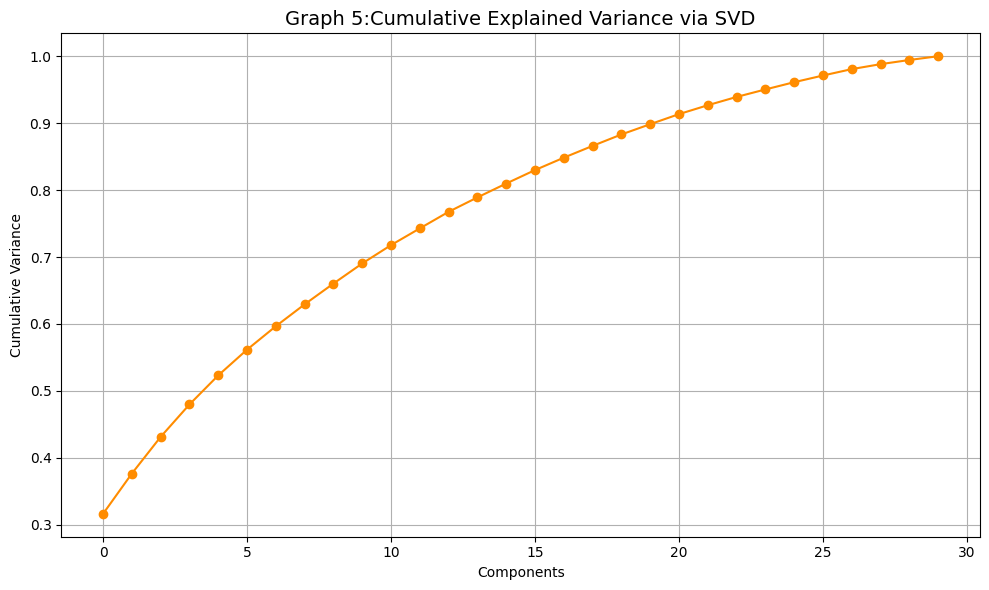

In [15]:
#Visuzlize Cumulative Explained Variance via SVD
explained_variance = S**2 / np.sum(S**2)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', color='darkorange')
plt.title("Graph 5:Cumulative Explained Variance via SVD", fontsize=14)
plt.xlabel("Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


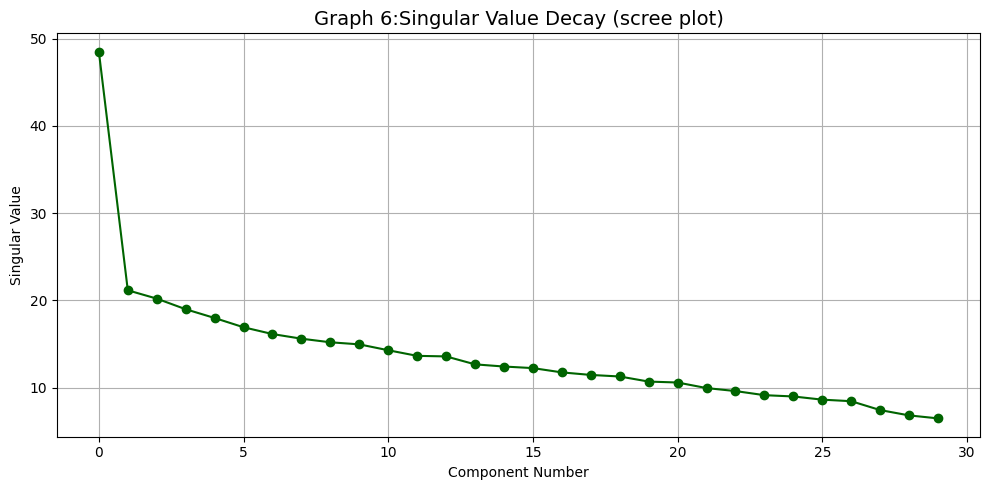

In [16]:
#Visuzlize singular values
plt.figure(figsize=(10, 5))
plt.plot(S, marker='o', linestyle='-', color='darkgreen')
plt.title("Graph 6:Singular Value Decay (scree plot)", fontsize=14)
plt.xlabel("Component Number")
plt.ylabel("Singular Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion

This empirical analysis of the SPDR® S&P Health Care Equipment ETF (XHE) examined the return behavior of its 30 largest holdings. The below summarize key findings from the analysis:

---

### c. Daily Returns

When analyzing the daily returns from June 2024 to June 2025, a few patterns emerge. During the first period (June to July 2024), the returns of the individual holdings were closely packed, and generally had similar movement the ETF. However, as the year went on the returns began spread high or lower from each other but they followed the same trend.




A notable change occurs after March 2025, which showed a decline in returns. This was likely due to macroeconomic instability atributted to political uncertainty that may have steemed form US Traiffs during that time. After May the returns found more stability.




Graph 2: Estimated Cumulative Return for the SPDR® S&P Health Care Equipment ETF shows the movements over the 12-month period. The drop between March and May 2025 is clearly visible and highlights a period of volatility.


#### **Why the use of log returns?**
Log returns log returns were used here to show the movement of the asset from a time-series data.


#### The value of calculating returns**
The value of the daily return patterns is a good measure of the short-term price fluctuations, which in turn helps investors evaluate the asset’s (ETF) risk and performance. These movements form the basis for calculating volatility and identifying potential return trends.


---

### d. Covariance Matrix


This highlights the behavior between two pairs of components it’s a pointer to the correlation of the components within the ETF.  

The blue ones tend to be less related whereas the red one or more related relation in terms of the movement so when one moves does the other one move with it or not. This in a weird sense even though it's in one ETF sector does point to a bit of diversification within the ETF. This can measure how much 2 tickers may be too closely related to actually be present in one ETF.

---

### e. Principal Component Analysis (PCA)

The value of the PCA is that it illustrates the weight of the variance (volatility) of each component.

Graph 4: Explained Variance by Principal Components (Scree Plot)

This is a visual representation of the EFT’s top 30 holding’s total variance impact on the return. It shows the cumulative effect of each principal component as its added.

#### Eigenvalues = Variance Explained

The Eigenvalues from the PCA are the values of the variance of each single component.

X-axis: Number of principal components

Y-axis: Cumulative explained variance

Each eigenvalue from PCA shoes the  amount of variance
What we notice from this particular graph is that from the first PC to the last PC the first PC has a larger variance amount whereas the smaller one has a smaller one. This means that there's a cumulative effect of the variance however going towards the end the last ones flatten out and in a sense can seem like they're negligible however they still have an impact just a smaller variance.

#### **Graph 4: Explained Variance by Principal Components (Scree Plot)**  
This visual representation...

---

### f. Singular Value Decomposition (SVD)


The SVD is a more powerful illustration of the variance...

#### **Graph 6: Singular Value Decay (Scree Plot)**  
The SVD is a more powerful illustration of the variance of each component. In the Graph 6: Singular Value Decay (Scree Plot). There is a clearer view of the variance the size of each component referred to as the singular value is much clearer.

The curve of this graph indicates the rate of the decline the in value of the variance of the singular values. The steeper the decline the higher the variance of the prior component.

References:

1. State Street Corporation: XHE SPDR® S&P® Health Care Equipment ETF

https://www.ssga.com/us/en/intermediary/etfs/spdr-sp-health-care-equipment-etf-xhe

